# Obesity Risk Prediction

Oleh: Crista Livia Budiman

Import Libraries and Modules


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle

Read CSV

In [2]:
df = pd.read_csv("ObesityDataSet1.csv")

# EDA

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,31,1.87,128.87,yes,yes,2.96,3.00,Sometimes,yes,1.28,no,0.90,1.875,Sometimes,Automobile,Obesity_Type_II
1,Female,18,1.59,40.00,yes,yes,2.00,1.00,Frequently,no,1.00,no,0.00,2.000,no,Public_Transportation,Insufficient_Weight
2,Female,44 years,1.59,77.00,yes,yes,2.00,3.00,Sometimes,no,2.81,no,0.00,0.000,Sometimes,Automobile,Obesity_Type_I
3,Male,31,1.68,102.00,yes,yes,2.94,2.14,Sometimes,no,1.25,no,1.18,0.778,no,Public_Transportation,Obesity_Type_II
4,Male,22,1.74,75.00,yes,yes,3.00,3.00,Frequently,no,1.00,no,1.00,0.000,no,Automobile,Normal_Weight


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1055 non-null   object 
 1   Age                             1055 non-null   object 
 2   Height                          1055 non-null   float64
 3   Weight                          1055 non-null   float64
 4   family_history_with_overweight  1055 non-null   object 
 5   FAVC                            1055 non-null   object 
 6   FCVC                            1055 non-null   float64
 7   NCP                             1055 non-null   float64
 8   CAEC                            1029 non-null   object 
 9   SMOKE                           1055 non-null   object 
 10  CH2O                            1055 non-null   float64
 11  SCC                             1055 non-null   object 
 12  FAF                             10

In [5]:
df.shape

(1055, 17)

In [6]:
df.duplicated().sum()

9

In [7]:
df.describe()

,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1018.000000
mean,1.703175,86.674521,2.422701,2.719649,2.018114,1.033118,0.676977
std,0.095162,26.213231,0.529695,0.749590,0.613095,0.850566,0.603165
min,1.460000,39.370000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.630000,65.135000,2.000000,2.765000,1.620000,0.160000,0.003250
50%,1.700000,83.150000,2.400000,3.000000,2.000000,1.000000,0.672500
75%,1.770000,107.125000,3.000000,3.000000,2.500000,1.730000,1.000000
max,1.980000,160.640000,3.000000,4.000000,3.000000,3.000000,2.000000


In [8]:
numerical = []
categorical = []

for i in df.columns:
    if df[i].dtype == 'object':
        categorical.append(i)
    elif "int" in str(df[i].dtype) or "float" in str(df[i].dtype):
        numerical.append(i)
        
print("numerical:",numerical)
print("categorical:",categorical)

numerical: ['Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical: ['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [9]:
for i in categorical:
    print(df[i].value_counts())
    print()

Gender
Male      536
Female    519
Name: count, dtype: int64

Age
26          108
18          101
21          101
23           97
22           87
19           87
20           79
24           53
25           46
31           33
17           32
30           24
27           22
29           20
33           16
39           14
34           14
37           13
32           11
38           11
40           11
41           11
28           11
35           10
16            8
42            4
18 years      4
21 years      3
36            3
26 years      2
43            2
55            2
44            2
51            1
20 years      1
45            1
47            1
32 years      1
22 years      1
23 years      1
61            1
52            1
19 years      1
44 years      1
56            1
33 years      1
Name: count, dtype: int64

family_history_with_overweight
yes    864
no     191
Name: count, dtype: int64

FAVC
yes    931
no     124
Name: count, dtype: int64

CAEC
Sometimes     871
Frequently    

In [10]:
df.isna().sum()

Gender                             0
Age                                0
Height                             0
Weight                             0
family_history_with_overweight     0
FAVC                               0
FCVC                               0
NCP                                0
CAEC                              26
SMOKE                              0
CH2O                               0
SCC                                0
FAF                                0
TUE                               37
CALC                               0
MTRANS                             0
NObeyesdad                         0
dtype: int64

Berdasarkan EDA, dapat diketahui bahwa dataset A memiliki:
* 1055 baris dan 17 kolom
* 7 numerical variable dan 10 categorical variable
* incorrect data type pada 'Age'
* 9 baris yang duplikat
* missing values sebanyak 26 baris pada 'CAEC' dan 37 baris pada 'TUE'

# Data Preprocessing

## Handle Incorrect Data Type

In [11]:
df['Age'] = df['Age'].astype(str).str.replace('years', '', regex=False).str.strip()
df['Age'].value_counts()

Age
26    110
18    105
21    104
23     98
22     88
19     88
20     80
24     53
25     46
31     33
17     32
30     24
27     22
29     20
33     17
39     14
34     14
37     13
32     12
38     11
40     11
28     11
41     11
35     10
16      8
42      4
44      3
36      3
43      2
55      2
56      1
52      1
61      1
51      1
45      1
47      1
Name: count, dtype: int64

In [12]:
df['Age'] = df['Age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1055 non-null   object 
 1   Age                             1055 non-null   int32  
 2   Height                          1055 non-null   float64
 3   Weight                          1055 non-null   float64
 4   family_history_with_overweight  1055 non-null   object 
 5   FAVC                            1055 non-null   object 
 6   FCVC                            1055 non-null   float64
 7   NCP                             1055 non-null   float64
 8   CAEC                            1029 non-null   object 
 9   SMOKE                           1055 non-null   object 
 10  CH2O                            1055 non-null   float64
 11  SCC                             1055 non-null   object 
 12  FAF                             10

Drop kolom yang duplikat

In [13]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

## Pipeline

In [14]:
target_col = 'NObeyesdad'
input_df = df.drop(columns=[target_col])
output_df = df[target_col]

In [15]:
numeric_features = input_df.select_dtypes(include=['int32','float64']).columns.tolist()
categorical_features = input_df.select_dtypes(include=['object']).columns.tolist()

In [16]:
print("Categorical features in input_df:",categorical_features,
      "\nNumeric features in input_df:",numeric_features)

Categorical features in input_df: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'] 
Numeric features in input_df: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


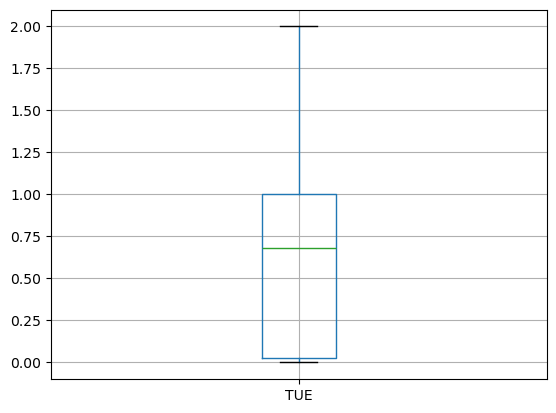

In [17]:
boxplot = df.boxplot(column=['TUE'])
plt.show()

impute missing values menggunakan mean karena tidak terdapat outlier

In [18]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])

In [19]:
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

In [20]:
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [21]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Age', 'Height', 'Weight', 'FCVC', 'NCP',
                                  'CH2O', 'FAF', 'TUE']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC',
                                  'MTRANS'])])

In [22]:
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [23]:
pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC',
                                                   'MTRANS'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [24]:
pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(random_state=42))
])

In [25]:
pipeline_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SC...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Data Splitting

In [26]:
x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size = 0.2, random_state = 42)

In [27]:
print("Train (x,y) :", x_train.shape, y_train.shape)
print("Test  (x,y) :", x_test.shape, y_test.shape)

Train (x,y) : (836, 16) (836,)
Test  (x,y) : (210, 16) (210,)


# Training Model

## Random Forest

In [28]:
pipeline_rf.fit(x_train, y_train)
y_pred_rf = pipeline_rf.predict(x_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

In [29]:
print(f"Random Forest Accuracy: {acc_rf:.3f}")

Random Forest Accuracy: 0.933


In [30]:
print('Classification Report\n')
print(classification_report(y_test, y_pred_rf))

Classification Report

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.96      0.96        28
      Normal_Weight       0.76      0.90      0.83        21
     Obesity_Type_I       0.97      0.95      0.96        39
    Obesity_Type_II       1.00      1.00      1.00        28
   Obesity_Type_III       1.00      1.00      1.00        29
 Overweight_Level_I       0.93      0.81      0.86        31
Overweight_Level_II       0.89      0.91      0.90        34

           accuracy                           0.93       210
          macro avg       0.93      0.93      0.93       210
       weighted avg       0.94      0.93      0.93       210



## XGBoost

In [31]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

In [32]:
pipeline_xgb.fit(x_train, y_train)
y_pred_xgb = pipeline_xgb.predict(x_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

In [33]:
print(f"XGBoost Accuracy: {acc_xgb:.3f}")

XGBoost Accuracy: 0.943


In [34]:
print('Classification Report\n')
print(classification_report(y_test, y_pred_xgb))

Classification Report

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.90      0.90      0.90        21
           2       0.95      0.97      0.96        39
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        29
           5       0.90      0.87      0.89        31
           6       0.86      0.88      0.87        34

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210



# Best Model

Berdasarkan hasil classification report kedua model tersebut, diketahui bahwa model XGBoost memiliki akurasi yang lebih tinggi yaitu sebesar 94.3%, sedangkan Random Forest sebesar 93.3%. Selain itu, XGBoost juga menunjukkan performa yang lebih konsisten di semua metric evaluasi, dengan nilai precision, recall, dan f1-score yang semuanya berada di atas 86% untuk setiap class. Sementara pada model Random Forest, terdapat beberapa metric yang nilainya berada di bawah 85%, seperti precision pada class Normal_Weight yang hanya sebesar 76% dan f1-score sebesar 83%, serta recall pada class Overweight_Level_I sebesar 81%. Oleh karena itu, dapat disimpulkan bahwa best model untuk dataset ini adalah XGBoost.

In [35]:
filename = 'model_XGB.pkl'
pickle.dump(pipeline_xgb, open(filename, 'wb'))